In [1]:
import os
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim
from IPython.display import IFrame

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [2]:
# Preprocessing
base_stopwords = set(stopwords.words('english'))
custom_stopwords = base_stopwords.union({'wiki', 'wikipedia', 'edit', 'article', 'page'})
lemmatizer = WordNetLemmatizer()

def preprocess(text: str):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in custom_stopwords]
    return tokens

# 2D Scatter
def plot_2d_scatter(X, title):
    plt.figure(figsize=(7, 6))
    plt.scatter(X[:, 0], X[:, 1], edgecolor='k', alpha=0.7)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.show()

# WordCloud (before preprocessing)
def plot_wordcloud_raw(text, title="Raw Text WordCloud"):
    wc = WordCloud(width=900, height=500, background_color="white").generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Extract top words for SVD / NMF
def get_top_words(model, feature_names, n_top=10):
    topics = []
    for topic_weights in model.components_:
        idx = topic_weights.argsort()[::-1][:n_top]
        topics.append([feature_names[i] for i in idx])
    return topics

# Extract top words for LDA
def get_lda_top_words(lda_model, num_words=15):
    topics = []
    for topic_id in range(lda_model.num_topics):
        words = [word for word, prob in lda_model.show_topic(topic_id, topn=num_words)]
        topics.append(words)
    return topics

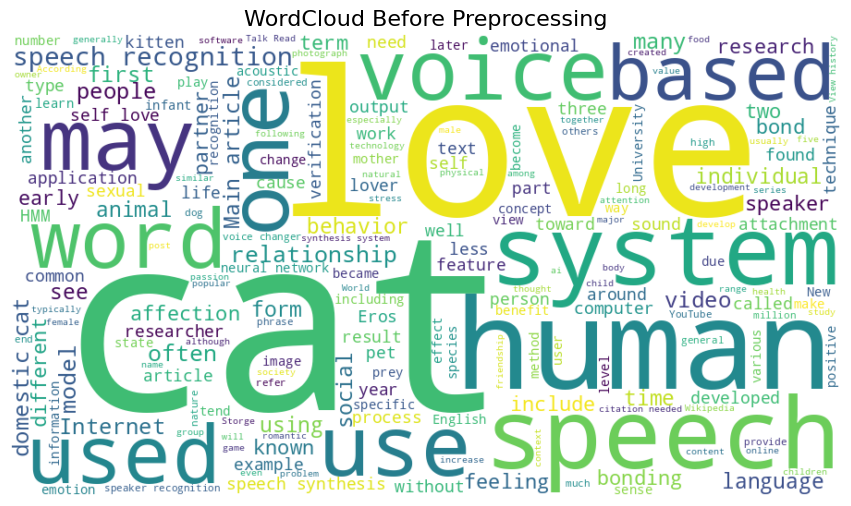

In [3]:
# Load data
path = "/kaggle/input/wikiarticles/wikiarticles.xlsx"
papers = pd.read_excel(path)

documents = papers["text"].astype(str).tolist()

# Raw WordCloud BEFORE preprocessing
raw_text_all = " ".join(documents)
plot_wordcloud_raw(raw_text_all, "WordCloud Before Preprocessing")

In [7]:
# Preprocess
tokenized = [preprocess(doc) for doc in documents]
clean_docs = [" ".join(t) for t in tokenized]
data_words = [d.split() for d in clean_docs]

# Dictionary & Corpus for LDA
id2word = corpora.Dictionary(data_words)
id2word.filter_extremes(no_below=2, no_above=0.5)
corpus = [id2word.doc2bow(text) for text in data_words]

# LDA models
lda_bow = gensim.models.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=3,
    iterations=200,
    random_state=42
)

tfidf_model = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf_model[corpus]

lda_tfidf = gensim.models.LdaModel(
    corpus=corpus_tfidf, id2word=id2word,
    num_topics=3, random_state=42
)

In [10]:
# LDA Visualization with pyLDAvis
vis_bow = pyLDAvis.gensim.prepare(lda_bow, corpus, id2word)
pyLDAvis.save_html(vis_bow, "LDA_BoW_visualization.html")

vis_tfidf = pyLDAvis.gensim.prepare(lda_tfidf, corpus_tfidf, id2word)
pyLDAvis.save_html(vis_tfidf, "LDA_TFIDF_visualization.html")

In [9]:
IFrame(src="LDA_BoW_visualization.html", width="100%", height="600")

In [11]:
IFrame(src="LDA_TFIDF_visualization.html", width="100%", height="600")

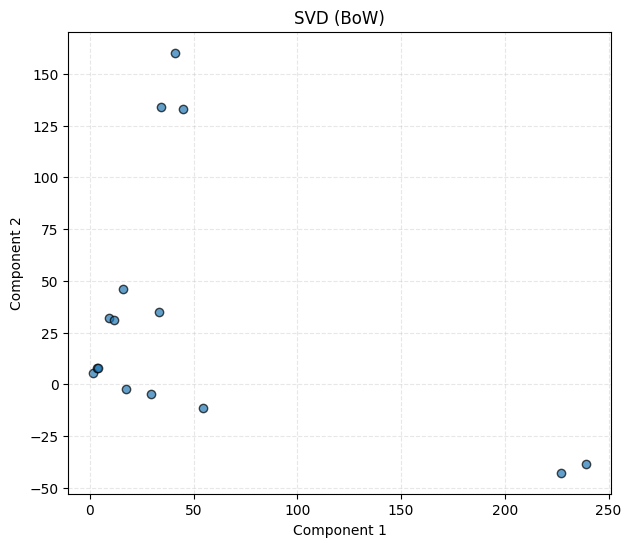

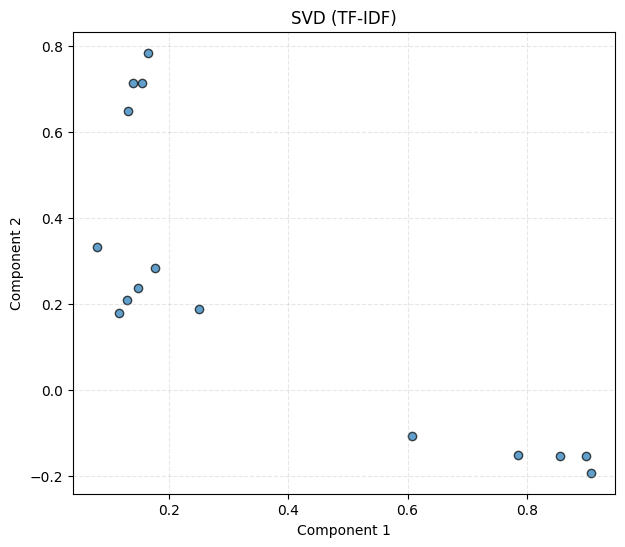

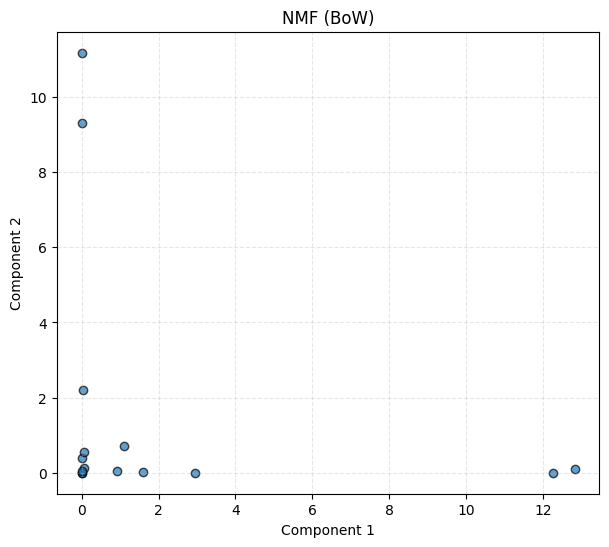

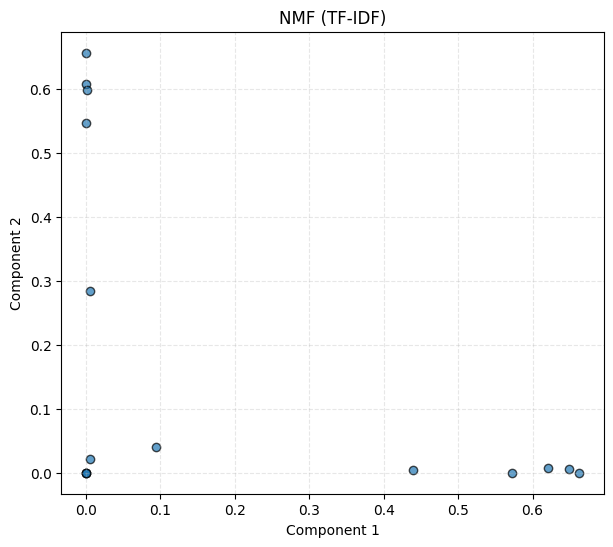

In [12]:
# LDA metrics
coherence_bow = CoherenceModel(lda_bow, texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()
coherence_tfidf = CoherenceModel(lda_tfidf, texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()
perplexity = lda_bow.log_perplexity(corpus)

# Vectorization
cv = CountVectorizer(max_features=1000, stop_words=list(custom_stopwords))
X_bow = cv.fit_transform(clean_docs)

tfidf_vec = TfidfVectorizer(max_features=1000, stop_words=list(custom_stopwords))
X_tfidf = tfidf_vec.fit_transform(clean_docs)

bow_feats = cv.get_feature_names_out()
tfidf_feats = tfidf_vec.get_feature_names_out()

# SVD
svd_bow = TruncatedSVD(n_components=3, random_state=42)
X_svd_bow = svd_bow.fit_transform(X_bow)

svd_tfidf = TruncatedSVD(n_components=3, random_state=42)
X_svd_tfidf = svd_tfidf.fit_transform(X_tfidf)

topics_svd_bow = get_top_words(svd_bow, bow_feats)
topics_svd_tfidf = get_top_words(svd_tfidf, tfidf_feats)

plot_2d_scatter(X_svd_bow[:, :2], "SVD (BoW)")
plot_2d_scatter(X_svd_tfidf[:, :2], "SVD (TF-IDF)")

coh_svd_bow = CoherenceModel(topics=topics_svd_bow, texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()
coh_svd_tfidf = CoherenceModel(topics=topics_svd_tfidf, texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()

# NMF
nmf_bow = NMF(n_components=3, random_state=42, init='nndsvd')
nmf_tfidf = NMF(n_components=3, random_state=42, init='nndsvd')

X_nmf_bow = nmf_bow.fit_transform(X_bow)
X_nmf_tfidf = nmf_tfidf.fit_transform(X_tfidf)

topics_nmf_bow = get_top_words(nmf_bow, bow_feats)
topics_nmf_tfidf = get_top_words(nmf_tfidf, tfidf_feats)

plot_2d_scatter(X_nmf_bow[:, :2], "NMF (BoW)")
plot_2d_scatter(X_nmf_tfidf[:, :2], "NMF (TF-IDF)")

coh_nmf_bow = CoherenceModel(topics=topics_nmf_bow, texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()
coh_nmf_tfidf = CoherenceModel(topics=topics_nmf_tfidf, texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()

In [13]:
# Compile a table
results = [
    ("LDA (BoW) Perplexity", perplexity, "lower_better"),
    ("LDA (BoW) Coherence", coherence_bow, "higher_better"),
    ("LDA (TF-IDF) Coherence", coherence_tfidf, "higher_better"),
    ("SVD (BoW) Coherence", coh_svd_bow, "higher_better"),
    ("SVD (TF-IDF) Coherence", coh_svd_tfidf, "higher_better"),
    ("NMF (BoW) Coherence", coh_nmf_bow, "higher_better"),
    ("NMF (TF-IDF) Coherence", coh_nmf_tfidf, "higher_better"),
]

df = pd.DataFrame(results, columns=["Model", "Score", "Sort"])

# Sort:

df_sorted = pd.concat([
    df[df["Sort"] == "higher_better"].sort_values("Score", ascending=False),
    df[df["Sort"] == "lower_better"].sort_values("Score", ascending=True)
])

# Output
print(df_sorted[["Model", "Score"]].to_string(index=False))

                 Model     Score
   NMF (BoW) Coherence  0.789108
   SVD (BoW) Coherence  0.687803
SVD (TF-IDF) Coherence  0.649910
NMF (TF-IDF) Coherence  0.635901
   LDA (BoW) Coherence  0.468034
LDA (TF-IDF) Coherence  0.446362
  LDA (BoW) Perplexity -7.277235
